Notes for HST photometry project

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
model = Table.read('../paper/saved_models/trappist-1_model_var_res_v07.ecsv')
mw, mf = model['WAVELENGTH'], model['FLUX']

Filters to look at 
 
 ACS/SBC F140LP - F165LP = C IV  
  F280N   
  F218W and F225W  
  
  

In [5]:
#uvispath = '/home/david/work/filters/wfc3/UVIS'
from svo_filters import svo

In [6]:
F280N = svo.Filter('WFC3_UVIS1.F280N')

In [7]:
F280N.info()

     Attributes                                                 Values                                          
-------------------- -------------------------------------------------------------------------------------------
            Comments />                                                                                         
        DetectorType 1                                                                                          
            Facility HST                                                                                        
FilterProfileService ivo://svo/fps                                                                              
          Instrument WFC3                                                                                       
              MagSys Vega                                                                                       
           PhotCalID HST/WFC3_UVIS1.F280N/Vega                                                  

In [8]:
filters =  ['WFC3_UVIS1.F280N', 'WFC3_UVIS1.F218W', 'WFC3_UVIS1.F225W', 'WFC3_UVIS1.F275W', 'ACS_SBC.F140LP', 'ACS_SBC.F165LP']

6.427503e-05
6.057676e-05
8.765822e-06
0.00012538218
5.507314e-05
1.0876631e-05


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


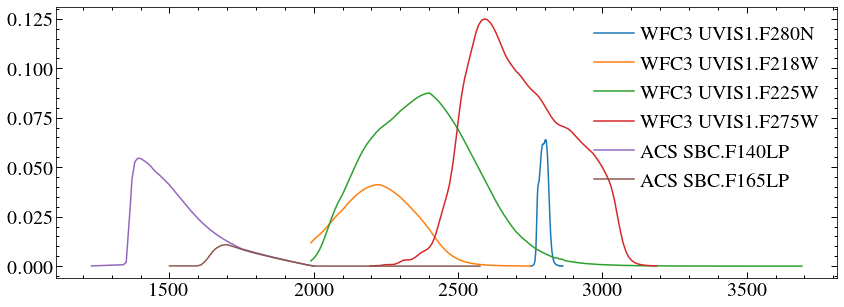

In [9]:
for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, bp.throughput[0]
    #print(bp.name)
    plt.plot(bpw, bpf, label = r'{}'.format(bp.name.replace('_', ' ')))
    print(min(bpf))

plt.legend()

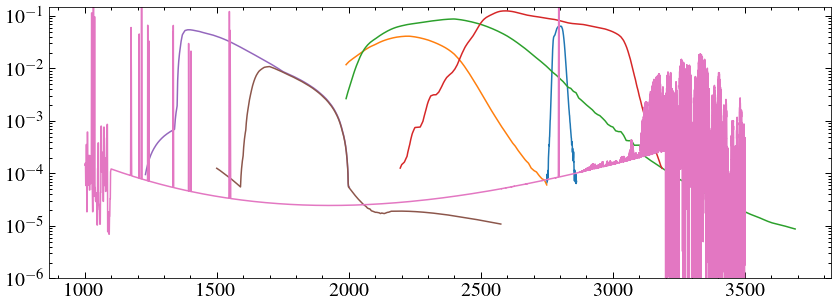

In [10]:

for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, bp.throughput[0]
    #print(bp.name)
    plt.plot(bpw, bpf, label = r'{}'.format(bp.name.replace('_', ' ')))

#plt.legend()
mask = (mw > 1000) & (mw < 3500)
umw, umf =  mw[mask], mf[mask]
plt.plot(umw, umf*5e14)
plt.ylim(0.000001, 0.15)
plt.yscale('log')

Plan- make a model spectrum file for each filter. Try with just a short one first,

In [11]:
for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = (bp.wave[0].value)*10000, bp.throughput[0]
    print(bpw[0], bpw[-1])

2750.5002 2863.0
1990.0 2750.0
1990.0 3691.0
2195.0 3186.9998
1230.0 2002.0001
1500.0 2576.0


In [12]:
#1230.0 3691.0
mask = (mw > 1220) & (mw < 3700)
umw, umf =  mw[mask], mf[mask]
savdat = Table([umw, umf], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 't1uv_model.dat', format='basic', overwrite=True)

Idea- get a MUSCLES  NUV spectrum, scale to T1 distance, see if that works as an input. GJ 581 is an M5

In [13]:
gjpath = '/media/david/5tb_storage1/mast_muscles/gj581/'
gj_sed = '{}hlsp_muscles_multi_multi_gj581_broadband_v22_adapt-var-res-sed.fits'.format(gjpath)
gjdata = fits.getdata(gj_sed,1)

(1700, 3000)

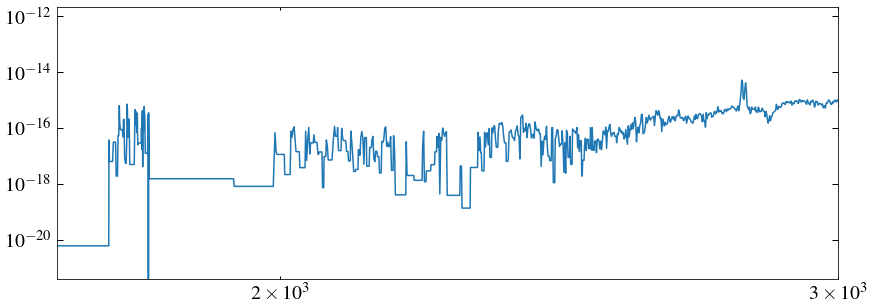

In [14]:
gw, gf = gjdata['WAVELENGTH'], gjdata['FLUX']
plt.plot(gw, gf)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1700,3000)

In [15]:
d_gj = (1/158.7491998297578e-3)*u.pc
d_t1 = 12.1*u.pc
print(d_gj)

6.299244349403948 pc


In [16]:
t1_nuv = Table.read('../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g230l_v6_component-spec.ecsv')
t1w, t1f = t1_nuv['WAVELENGTH'], t1_nuv['FLUX']

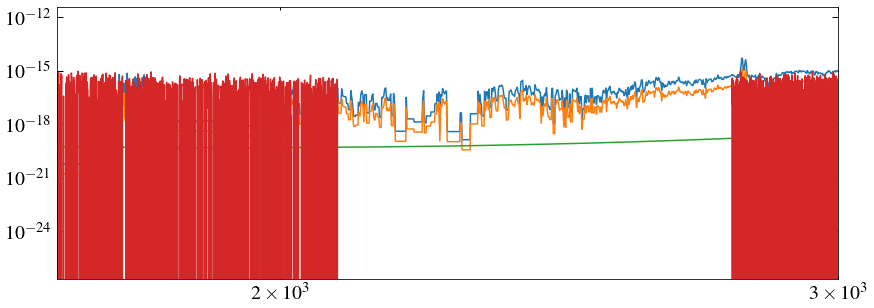

In [17]:
scale = (d_gj/d_t1)**2
plt.plot(gw, gf)
plt.plot(gw, gf*scale)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1700,3000)
plt.plot(umw, umf)
plt.plot(t1w, t1f)

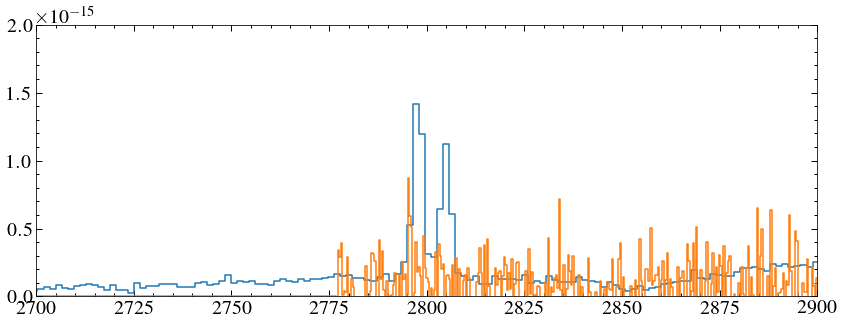

In [18]:
plt.step(gw, gf*scale, where='mid')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(2700, 2900)
plt.ylim(0, 2e-15)
plt.step(t1w, t1f, where='mid')

Probably not? Can say it's a rough approximation for the etc

In [19]:
mask = (gw > 1220) & (gw < 3700)
ugjw, ujgf =  gw[mask], gf[mask]
savdat = Table([ugjw, ujgf*scale], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'scaled_M5_uv.dat', format='basic', overwrite=True)

In [20]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')
w, f, e = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

In [21]:
uvmask = (w > 1250) & (w < 3500)
t1w, t1f, t1e = w[uvmask],f[uvmask], e[uvmask]

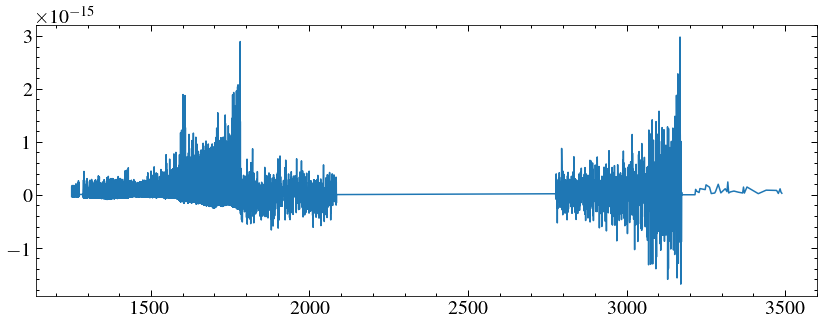

In [22]:
plt.plot(t1w, t1f)

Just plot the raw spectra with emission lines noted and filters?

In [23]:
components = glob.glob('../test_files/components/*.ecsv')
components


['../test_files/components/hlsp_muscles_model_dem_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_apec_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g130m_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g160m_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_phx_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_lya-reconstruction_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g430l_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g140m_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g230l_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_xmm_epic_2mass-j230

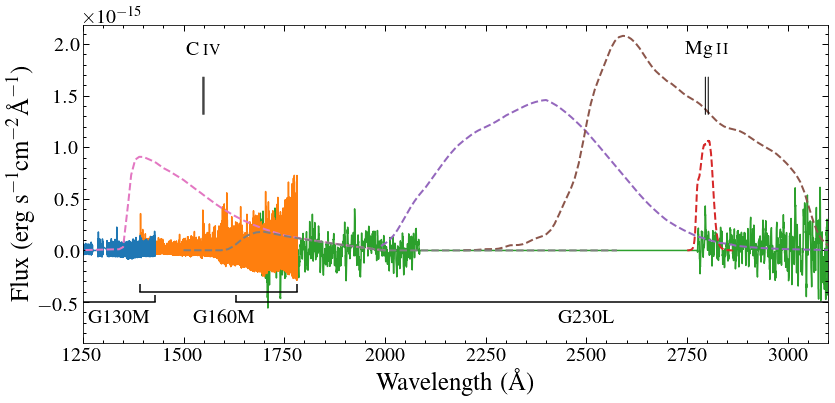

In [24]:
filters =  ['WFC3_UVIS1.F280N', 'WFC3_UVIS1.F225W', 'WFC3_UVIS1.F275W', 'ACS_SBC.F140LP', 'ACS_SBC.F165LP']

plt.figure(figsize=(12, 6))
w0s = []
w1s = []
for i, spec in enumerate([components[2], components[3], components[8]]):
    data = Table.read(spec)
    w, f = data['WAVELENGTH'], data['FLUX']
    #airglow =  [1207, 1222, 1300, 1310, 1353, 1356]
    mask = (w < 1207) | (w > 1222) & (w < 1300) | (w > 1310) & (w < 1353) | (w > 1356) 
    w, f = w[mask], np.array(f[mask])
    f = convolve(f,Box1DKernel(5))
    plt.plot(w, f, zorder=-i)
    w0s.append(w[0])
    w1s.append(w[-1])
plt.ylim(-0.9e-15, 2.19e-15)
#plt.xscale('log')
for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, (bp.throughput[0]/6e13)
    #print(bp.name)
    plt.plot(bpw, bpf, lw=2, ls='--', label = r'{}'.format(bp.name.replace('_', ' ')))
plt.xlim(1250, 3100)

liney = -0.5e-15
labely = -0.7e-15
ticklength = 0.1*abs(labely)
plt.errorbar((w0s[0],w1s[0]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G130M', (1340, labely), horizontalalignment='center')

plt.errorbar((w0s[1],w1s[1]),(0.8*liney, 0.8*liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G160M', (1600, labely), horizontalalignment='center')

plt.errorbar((w0s[2],w1s[2]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G230L', (2500, labely), horizontalalignment='center')

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
plt.xlabel('Wavelength (\AA)', size=25)

c4 = [1548.195, 1550.77]
mg2 = [2795.523, 2802.697]

names = ['C\,{\sc iv}', 'Mg\,{\sc ii}']
lines = [c4, mg2]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 1.3e-15), xytext=(line, 1.7e-15),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 2.e-15), xytext=(np.mean(si), 1.9e-15), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

#plt.legend(loc=1)

plt.tight_layout()

Same plot but with zoom in panels on the lines

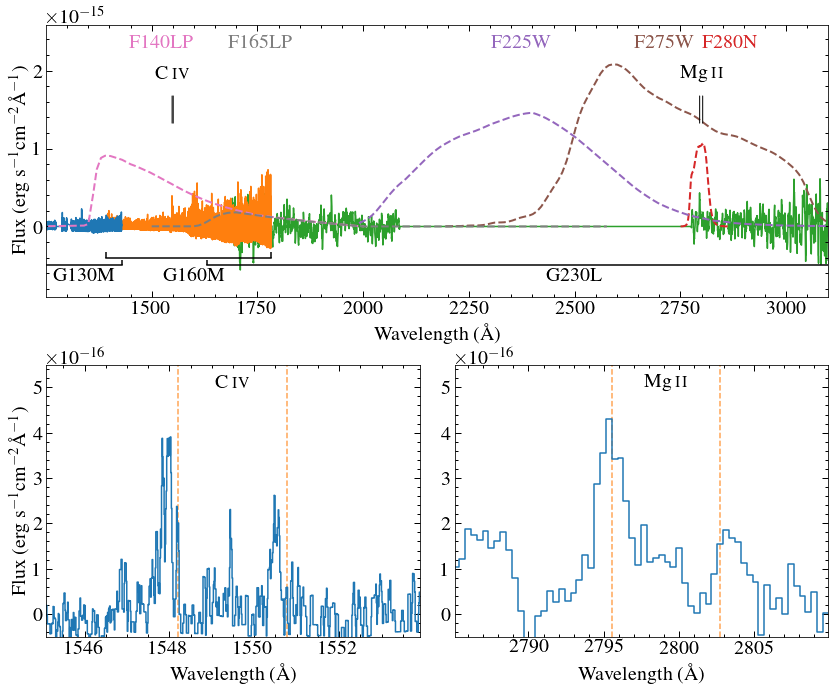

In [40]:
## filters =  ['WFC3_UVIS1.F280N', 'WFC3_UVIS1.F225W', 'WFC3_UVIS1.F275W', 'ACS_SBC.F140LP', 'ACS_SBC.F165LP']

plt.figure(figsize=(12, 10))
plt.subplot(211)

w0s = []
w1s = []
for i, spec in enumerate([components[2], components[3], components[8]]):
    data = Table.read(spec)
    w, f = data['WAVELENGTH'], data['FLUX']
    #airglow =  [1207, 1222, 1300, 1310, 1353, 1356]
    mask = (w < 1207) | (w > 1222) & (w < 1300) | (w > 1310) & (w < 1353) | (w > 1356) 
    w, f = w[mask], np.array(f[mask])
    f = convolve(f,Box1DKernel(5))
    plt.plot(w[50:-50], f[50:-50], zorder=-i)
    w0s.append(w[0])
    w1s.append(w[-1])
plt.ylim(-0.9e-15, 2.59e-15)
#plt.xscale('log')

shift = [70, 0, 0, 0,0]# ofset filter labels
for i, flt in enumerate(filters):
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, (bp.throughput[0]/6e13)
    #print(bp.name)
    plt.plot(bpw, bpf, lw=2, ls='--', label = r'{}'.format(bp.name.replace('_', ' ')), c='C{}'.format(i+3))
    label = bp.name[bp.name.find('.')+1:]
    plt.annotate(label, (bp.WavelengthRef+shift[i], 2.3e-15), horizontalalignment='center', c='C{}'.format(i+3))
plt.xlim(1251, 3099)

liney = -0.5e-15
labely = -0.7e-15
ticklength = 0.1*abs(labely)
plt.errorbar((w0s[0],w1s[0]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G130M', (1340, labely), horizontalalignment='center')

plt.errorbar((w0s[1],w1s[1]),(0.8*liney, 0.8*liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G160M', (1600, labely), horizontalalignment='center')

plt.errorbar((w0s[2],w1s[2]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G230L', (2500, labely), horizontalalignment='center')

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
plt.xlabel('Wavelength (\AA)', size=20)

c4 = [1548.195, 1550.77]
mg2 = [2795.523, 2802.697]

names = ['C\,{\sc iv}', 'Mg\,{\sc ii}']
lines = [c4, mg2]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 1.3e-15), xytext=(line, 1.7e-15),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 2.e-15), xytext=(np.mean(si), 1.9e-15), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

#plt.legend(loc=1)


plt.subplot(223)
data = Table.read(components[3])
w, f = data['WAVELENGTH'], np.array(data['FLUX'])
#w, f = w[mask], np.array(f[mask])
f = convolve(f,Box1DKernel(5))
plt.step(w, f, where='mid')
plt.xlim(1545.1, 1553.9)
plt.ylim(-0.5e-16, 5.5e-16)


#[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
[plt.axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in c4]
plt.annotate(names[0],(np.mean(c4), 5e-16), xytext=(np.mean(c4), 5e-16), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
plt.xlabel('Wavelength (\AA)', size=20)



plt.subplot(224)
data = Table.read(components[8])
w, f = data['WAVELENGTH'], np.array(data['FLUX'])
#w, f = w[mask], np.array(f[mask])
f = convolve(f,Box1DKernel(5))
plt.step(w, f, where='mid')
plt.xlim(2785.1, 2809.9)
plt.ylim(-0.5e-16, 5.5e-16)


#[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
[plt.axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in mg2]
plt.annotate(names[1],(np.mean(mg2), 5e-16), xytext=(np.mean(mg2), 5e-16), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
#plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
plt.xlabel('Wavelength (\AA)', size=20)


plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('filters_and_lines.pdf')

In [26]:
bp =  svo.Filter(flt)

In [27]:
bp

In [30]:
bp.name[bp.name.find('.')+1:]

'F165LP'